<a href="https://colab.research.google.com/github/DrLennon666/DAT4-students/blob/master/GAN_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

TensorFlow 2.x selected.


In [2]:
import numpy as np
import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


Generate real data and plot.

In [0]:
x = np.random.uniform(-1,1,10000)
y = np.sin(4*x)
data = np.stack((x,y), 1)

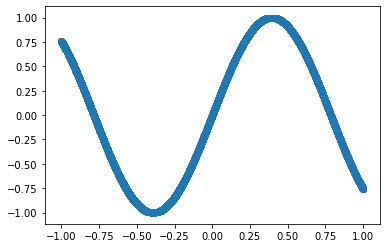

In [31]:
plt.scatter(x,y)
plt.show()

In [0]:
def generate_discriminator(input_shape=2):
'''
Define and compile the discriminator network.
the input is an x,y pair of the distribution to be learned
'''
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(16, activation='relu', 
                                 kernel_initializer='he_uniform', 
                                 input_dim=input_shape))
  model.add(tf.keras.layers.Dense(16, activation='relu',
                                  kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
  return model

def generate_generator(input_shape=3, output_shape=2):
'''
Define the genrator model. This model accepts a 1x3 vector
of Gaussian noise and outputs x,y pairs.
The model is not compiled as it is not trained directly.
'''
  model = tf.keras.Sequential()
  model.add(tf.keras.layers.Dense(16, activation = 'relu',
                                  kernel_initializer='he_uniform',
                                  input_dim=input_shape))
  model.add(tf.keras.layers.Dense(16, activation='relu',
                                  kernel_initializer='he_uniform'))
  model.add(tf.keras.layers.Dense(output_shape, activation='linear'))

  return model

def combined_gen_disc(gen, disc):

  '''
  Stack the generator and discriminator. This model is compiled
  but the weights of the discriminator are not updated. The loss
  of the stacked model is used to update the weights of the 
  generator.
  '''
  disc.trainable=False
  model = tf.keras.Sequential()
  model.add(gen)
  model.add(disc)
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

In [0]:
# Define the models
discriminator = generate_discriminator()
generator = generate_generator()
stacked = combined_gen_disc(generator, discriminator)

In [28]:
# Train the discriminator and stacked model.

batch_size = 64
epochs = 10000

for i in range(epochs):
  # Choose random batch of data of size half of the batch size and label
  # as real.
  half_batch_idx = np.random.randint(0,data.shape[0], batch_size)
  half_real_data = data[half_batch_idx]
  # label real data as ones, note the shape is n x 1. 
  # needed to add the column dimension.

  real_labels = np.ones((half_real_data.shape[0],1))

  # Generate random Gaussian noise and feed to generator network
  # to generate a half batch of fake data. Create labels.
  noise = np.random.randn(batch_size,3)
  half_fake_data = generator(noise)
  # again added the column dim.
  fake_labels = np.zeros((half_fake_data.shape[0],1))

  # Generate random Gaussian noise and feed to stacked network.
  noise = np.random.randn(batch_size,3)
  generated_data = generator(noise)
  generated_labels = np.ones((noise.shape[0],1))

  # Train discriminator on real and fake half batches
  history_real = discriminator.fit(half_real_data, real_labels, verbose=0)
  history_fake = discriminator.fit(half_fake_data, fake_labels, verbose =0)

  history_stacked = stacked.fit(noise, generated_labels, verbose=0)

  if i%1000 ==0:
    print(i)
    print('real', history_real.__dict__['history']['loss'])
    print('fake', history_fake.__dict__['history']['loss'])
    print('stacked', history_stacked.__dict__['history']['loss'])

0
real [0.707372784614563]
fake [0.660450667142868]
1000
real [0.6616074740886688]
fake [0.6695310473442078]
2000
real [0.658218652009964]
fake [0.6502715647220612]
3000
real [0.6535497307777405]
fake [0.6459116339683533]
4000
real [0.6612668037414551]
fake [0.6418148875236511]
5000
real [0.6674532294273376]
fake [0.6805123090744019]
6000
real [0.6513858437538147]
fake [0.6762011647224426]
7000
real [0.662776380777359]
fake [0.6469886898994446]
8000
real [0.6542212069034576]
fake [0.6997981667518616]
9000
real [0.6675196886062622]
fake [0.6648907959461212]


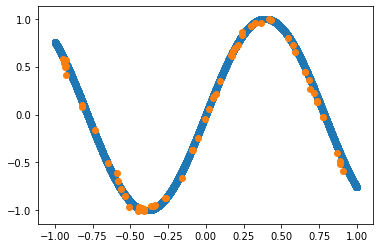

In [30]:
outs = generator.predict(noise)
plt.scatter(x,y)
plt.scatter(outs[:,0], outs[:,1])
plt.show()